In [847]:
import numpy as np
import pandas as pd
from sklearn import metrics
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import EarlyStopping , ReduceLROnPlateau , ModelCheckpoint
from keras.models import load_model
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.3f}'.format

In [848]:
# network structure. 
# not to include the input layer
net_layers = (3,2)

epochs=200
batch_size=300

learning_rate = 1e-3
decay = learning_rate / epochs

patience=80

test_split = 0.1
validation_split = 0.2

# trials
# 11 R2-> -0.12
# 11,16,8,4 R2-> 0.37
# 11,11,6 R2-> -0.2
# 11,8,6 R2->   0.316
# 11,11,8,4 R2->  0.37
# 11, 6 R2-> 0.37

In [849]:
# 1- read data file
# 1- read processed file
file_dir = '../data/processed-data/'
data_file = 'normalized_dataset.csv'
#data_file = 'standardized_normalized_dataset.csv'
data = pd.read_csv(file_dir + data_file)

In [850]:
data.head(5)

,ltcy,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,svc_req_size,svc_resp_size,svc_pods,svc_req_rate
0,0.332,0.557,0.332,0.325,0.037,16.982,1.591,3.206,0.002,0.012,7.000,0.980
1,0.400,0.616,0.300,0.351,0.047,20.583,1.608,3.552,0.003,0.019,7.000,1.620
2,0.469,0.608,0.316,0.362,0.039,19.448,1.390,3.586,0.003,0.024,7.000,2.180
3,0.490,0.624,0.300,0.362,0.108,17.319,1.730,3.512,0.003,0.022,6.000,2.130
4,0.500,0.608,0.316,0.374,0.133,16.650,1.917,3.449,0.003,0.023,3.000,2.220


In [851]:
data.shape

(1584, 12)

In [852]:
targets = data['ltcy']
inputs = data.drop(['ltcy'], axis=1)

n_features = inputs.values.shape[1]
print("there are {} features".format(n_features))

there are 11 features


# Feature Selection

In [853]:
if True:
    sfm = SelectFromModel(
                RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=15),
                threshold='0.8*mean')

    selectedFeatures = sfm.fit(inputs, targets).transform(inputs)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))

    feature_list = inputs.columns[sfm.get_support()]
    features = ''
    features = ', '.join(feature_list)
    
    print("columns selected are {}".format(features))

    inputs = inputs[feature_list]
    inputs.head(2)

4 features selected
columns selected are svc_cpu_thr, system_cpu_use, system_cpu_sat, svc_req_rate


In [854]:
n_inputs = selectedFeatures[1].shape[0]

In [855]:
x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=True, random_state=365)

print("y_train {} , y_test {}".format(y_train.shape, y_test.shape))

# for better convergence and result scale target to values between 0 - 1
y_train_max = y_train.max()
y_test_max = y_test.max()

y_train = y_train / y_train_max
y_test = y_test / y_test_max


y_train (1425,) , y_test (159,)


In [856]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)  # fit on training data only
x_test = scaler.transform(x_test)

## Function to build a model

In [857]:
def build_keras_model(nodes = net_layers):   # this does not work with KerasRegressor. interesting
    # create model
    model = Sequential()  
    
    #if isinstance(nodes, int):
    if not nodes:
        model.add(Dense(1, input_dim=n_inputs, kernel_initializer='normal'))
    
    else:
        model.add(Dense(nodes[1], input_dim=n_inputs, kernel_initializer='normal', activation='relu'))
    
        layer = 0
        while layer < len(nodes):
            model.add(Dense(nodes[layer], kernel_initializer='normal', activation='relu'))
            layer = layer + 1
        
        #model.add(Dense(1, kernel_initializer='normal', activation='linear')) 
        model.add(Dense(1, kernel_initializer='normal'))  
    
    adam = Adam(lr=learning_rate, decay=decay)
    
    # or loss= 'mean_absolute_percentage_error'
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
    
    return model


In [858]:
model = build_keras_model()

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

# save the best model only
mc = ModelCheckpoint('../models/best_mlp_model.h5'
                     , monitor='val_loss'
                     , mode='min' 
                     , verbose=1
                     #, save_weights_only=True
                     , save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [es, mc, reduce_lr]

history = model.fit(x_train, y_train
                    , epochs=epochs
                    , batch_size=batch_size
                    , verbose=1
                    , validation_split=validation_split
                    , shuffle=False
                    , callbacks=callbacks)

print ("Done..!")


Train on 1140 samples, validate on 285 samples
Epoch 1/200
1140/1140 [==============================] - 6s 5ms/step - loss: 0.4283 - mean_squared_error: 0.4283 - val_loss: 0.4397 - val_mean_squared_error: 0.4397

Epoch 00001: val_loss improved from inf to 0.43968, saving model to ../models/best_mlp_model.h5
Epoch 2/200
1140/1140 [==============================] - 0s 19us/step - loss: 0.4232 - mean_squared_error: 0.4232 - val_loss: 0.4346 - val_mean_squared_error: 0.4346

Epoch 00002: val_loss improved from 0.43968 to 0.43456, saving model to ../models/best_mlp_model.h5
Epoch 3/200
1140/1140 [==============================] - 0s 20us/step - loss: 0.4182 - mean_squared_error: 0.4182 - val_loss: 0.4295 - val_mean_squared_error: 0.4295

Epoch 00003: val_loss improved from 0.43456 to 0.42948, saving model to ../models/best_mlp_model.h5
Epoch 4/200
1140/1140 [==============================] - 0s 16us/step - loss: 0.4132 - mean_squared_error: 0.4132 - val_loss: 0.4244 - val_mean_squared_error


Epoch 00031: val_loss improved from 0.30864 to 0.30477, saving model to ../models/best_mlp_model.h5
Epoch 32/200
1140/1140 [==============================] - 0s 15us/step - loss: 0.2909 - mean_squared_error: 0.2909 - val_loss: 0.3009 - val_mean_squared_error: 0.3009

Epoch 00032: val_loss improved from 0.30477 to 0.30094, saving model to ../models/best_mlp_model.h5
Epoch 33/200
1140/1140 [==============================] - 0s 16us/step - loss: 0.2872 - mean_squared_error: 0.2872 - val_loss: 0.2972 - val_mean_squared_error: 0.2972

Epoch 00033: val_loss improved from 0.30094 to 0.29715, saving model to ../models/best_mlp_model.h5
Epoch 34/200
1140/1140 [==============================] - 0s 16us/step - loss: 0.2835 - mean_squared_error: 0.2835 - val_loss: 0.2934 - val_mean_squared_error: 0.2934

Epoch 00034: val_loss improved from 0.29715 to 0.29340, saving model to ../models/best_mlp_model.h5
Epoch 35/200
1140/1140 [==============================] - 0s 17us/step - loss: 0.2798 - mean_sq

1140/1140 [==============================] - 0s 20us/step - loss: 0.1949 - mean_squared_error: 0.1949 - val_loss: 0.2038 - val_mean_squared_error: 0.2038

Epoch 00062: val_loss improved from 0.20649 to 0.20376, saving model to ../models/best_mlp_model.h5
Epoch 63/200
1140/1140 [==============================] - 0s 15us/step - loss: 0.1923 - mean_squared_error: 0.1923 - val_loss: 0.2011 - val_mean_squared_error: 0.2011

Epoch 00063: val_loss improved from 0.20376 to 0.20107, saving model to ../models/best_mlp_model.h5
Epoch 64/200
1140/1140 [==============================] - 0s 17us/step - loss: 0.1897 - mean_squared_error: 0.1897 - val_loss: 0.1984 - val_mean_squared_error: 0.1984

Epoch 00064: val_loss improved from 0.20107 to 0.19841, saving model to ../models/best_mlp_model.h5
Epoch 65/200
1140/1140 [==============================] - 0s 17us/step - loss: 0.1871 - mean_squared_error: 0.1871 - val_loss: 0.1958 - val_mean_squared_error: 0.1958

Epoch 00065: val_loss improved from 0.198


Epoch 00092: val_loss improved from 0.13787 to 0.13601, saving model to ../models/best_mlp_model.h5
Epoch 93/200
1140/1140 [==============================] - 0s 16us/step - loss: 0.1265 - mean_squared_error: 0.1265 - val_loss: 0.1342 - val_mean_squared_error: 0.1342

Epoch 00093: val_loss improved from 0.13601 to 0.13418, saving model to ../models/best_mlp_model.h5
Epoch 94/200
1140/1140 [==============================] - 0s 16us/step - loss: 0.1247 - mean_squared_error: 0.1247 - val_loss: 0.1324 - val_mean_squared_error: 0.1324

Epoch 00094: val_loss improved from 0.13418 to 0.13237, saving model to ../models/best_mlp_model.h5
Epoch 95/200
1140/1140 [==============================] - 0s 19us/step - loss: 0.1230 - mean_squared_error: 0.1230 - val_loss: 0.1306 - val_mean_squared_error: 0.1306

Epoch 00095: val_loss improved from 0.13237 to 0.13059, saving model to ../models/best_mlp_model.h5
Epoch 96/200
1140/1140 [==============================] - 0s 18us/step - loss: 0.1213 - mean_sq

1140/1140 [==============================] - 0s 16us/step - loss: 0.0831 - mean_squared_error: 0.0831 - val_loss: 0.0898 - val_mean_squared_error: 0.0898

Epoch 00123: val_loss improved from 0.09095 to 0.08977, saving model to ../models/best_mlp_model.h5
Epoch 124/200
1140/1140 [==============================] - 0s 17us/step - loss: 0.0820 - mean_squared_error: 0.0820 - val_loss: 0.0886 - val_mean_squared_error: 0.0886

Epoch 00124: val_loss improved from 0.08977 to 0.08860, saving model to ../models/best_mlp_model.h5
Epoch 125/200
1140/1140 [==============================] - 0s 18us/step - loss: 0.0808 - mean_squared_error: 0.0808 - val_loss: 0.0875 - val_mean_squared_error: 0.0875

Epoch 00125: val_loss improved from 0.08860 to 0.08745, saving model to ../models/best_mlp_model.h5
Epoch 126/200
1140/1140 [==============================] - 0s 17us/step - loss: 0.0797 - mean_squared_error: 0.0797 - val_loss: 0.0863 - val_mean_squared_error: 0.0863

Epoch 00126: val_loss improved from 0.


Epoch 00153: val_loss improved from 0.06255 to 0.06183, saving model to ../models/best_mlp_model.h5
Epoch 154/200
1140/1140 [==============================] - 0s 17us/step - loss: 0.0554 - mean_squared_error: 0.0554 - val_loss: 0.0611 - val_mean_squared_error: 0.0611

Epoch 00154: val_loss improved from 0.06183 to 0.06112, saving model to ../models/best_mlp_model.h5
Epoch 155/200
1140/1140 [==============================] - 0s 15us/step - loss: 0.0547 - mean_squared_error: 0.0547 - val_loss: 0.0604 - val_mean_squared_error: 0.0604

Epoch 00155: val_loss improved from 0.06112 to 0.06042, saving model to ../models/best_mlp_model.h5
Epoch 156/200
1140/1140 [==============================] - 0s 15us/step - loss: 0.0540 - mean_squared_error: 0.0540 - val_loss: 0.0597 - val_mean_squared_error: 0.0597

Epoch 00156: val_loss improved from 0.06042 to 0.05974, saving model to ../models/best_mlp_model.h5
Epoch 157/200
1140/1140 [==============================] - 0s 20us/step - loss: 0.0534 - mea

1140/1140 [==============================] - 0s 15us/step - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0449 - val_mean_squared_error: 0.0449

Epoch 00184: val_loss improved from 0.04527 to 0.04486, saving model to ../models/best_mlp_model.h5
Epoch 185/200
1140/1140 [==============================] - 0s 17us/step - loss: 0.0395 - mean_squared_error: 0.0395 - val_loss: 0.0445 - val_mean_squared_error: 0.0445

Epoch 00185: val_loss improved from 0.04486 to 0.04447, saving model to ../models/best_mlp_model.h5
Epoch 186/200
1140/1140 [==============================] - 0s 19us/step - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.0441 - val_mean_squared_error: 0.0441

Epoch 00186: val_loss improved from 0.04447 to 0.04408, saving model to ../models/best_mlp_model.h5
Epoch 187/200
1140/1140 [==============================] - 0s 17us/step - loss: 0.0387 - mean_squared_error: 0.0387 - val_loss: 0.0437 - val_mean_squared_error: 0.0437

Epoch 00187: val_loss improved from 0.

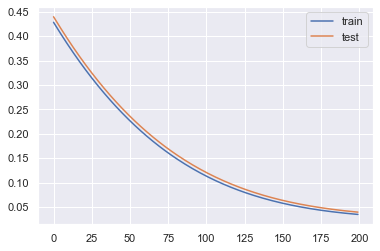

In [859]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [860]:
val_loss = history.history['val_loss']
val_loss_df = pd.DataFrame(val_loss)

print("Model Validation MSE mean: %.2f  std: (%.2f)" % \
      (val_loss_df.mean(), val_loss_df.std()))


Model Validation MSE mean: 0.16  std: (0.11)


In [861]:
# load the saved model
saved_model = load_model('../models/best_mlp_model.h5')

# evaluate the model
train_loss, train_mse = saved_model.evaluate(x_train, y_train, verbose=0)
test_loss, test_mse = saved_model.evaluate(x_test, y_test, verbose=0)
print('Train MSE: %.3f, Test MSE: %.3f' % (train_acc, test_acc))

Train MSE: 0.015, Test MSE: 0.012


In [862]:
#regressor.fit(x_train, y_train)
y_hat = saved_model.predict(x_train)
y_hat

array([[0.53463936],
       [0.53463936],
       [0.53463936],
       ...,
       [0.53463936],
       [0.53463936],
       [0.53463936]], dtype=float32)

In [863]:
r2_train = metrics.r2_score(y_train, y_hat)
print('R2 (training) = {}'.format(r2_train))

R2 (training) = -0.44431412825789196


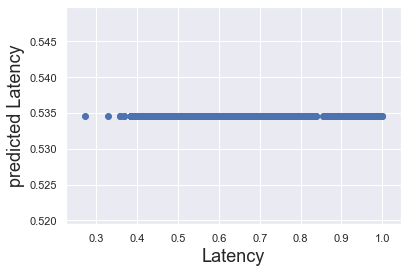

In [864]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

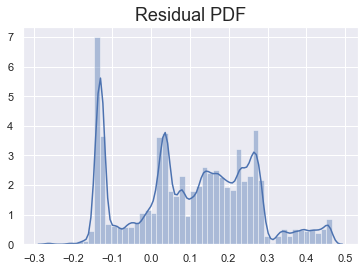

In [865]:
y_train = y_train.values
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

In [866]:
# evaluation mean_absolute_percentage_error
train_error =  y_train - y_hat
train_error

mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)

print("Train Residual mean: %.2f std: %.2f  min; %.2f max: %.2f" \
      % (mean_error, std_error, min_error, max_error))

Train Residual mean: 0.10 std: 0.16  min; -0.26 max: 0.47


### Testing

In [867]:
y_hat_test = saved_model.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

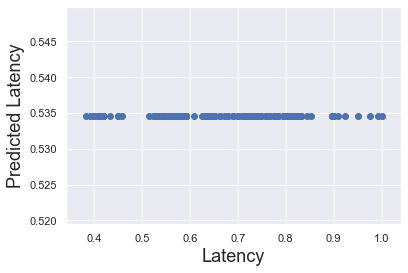

In [868]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

In [869]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,1.707,1.785
1,1.707,1.796
2,1.707,1.697
3,1.707,2.298
4,1.707,1.838


In [870]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,1.707,1.785,-0.078,4.374
1,1.707,1.796,-0.089,4.946
2,1.707,1.697,0.010,0.577
3,1.707,2.298,-0.591,25.726
4,1.707,1.838,-0.131,7.147
...,...,...,...,...
154,1.707,2.269,-0.562,24.777
155,1.707,1.506,0.201,13.311
156,1.707,2.043,-0.336,16.460
157,1.707,1.891,-0.184,9.717


In [871]:
perf.describe()

,prediction,target,residual,difference%
count,159.000,159.000,159.000,159.000
mean,1.707,1.925,-0.219,14.793
std,0.000,0.305,0.305,8.557
min,1.707,1.467,-1.011,0.082
25%,1.707,1.697,-0.470,9.468
50%,1.707,1.922,-0.215,13.474
75%,1.707,2.177,0.010,21.581
max,1.707,2.718,0.240,37.209


In [872]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
9,1.71,1.71,-0.00,0.08
37,1.71,1.70,0.01,0.58
2,1.71,1.70,0.01,0.58
117,1.71,1.70,0.01,0.58
49,1.71,1.70,0.01,0.58
68,1.71,1.72,-0.01,0.73
142,1.71,1.72,-0.01,0.73
51,1.71,1.72,-0.01,0.73
20,1.71,1.69,0.02,1.25
55,1.71,1.73,-0.02,1.36


# Prediction Accuracy

In [873]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

R2 (testing) = -0.46298537393657835
